# 介紹 #

在第 2 課和第 3 課中，我們將預測視為一個簡單的迴歸問題，我們的所有特徵都來自單個輸入，即時間索引。只需生成我們想要的趨勢和季節性特徵，我們就可以輕鬆地創建未來任何時間的預測。

然而，當我們在第 4 課中添加滯後特徵時，問題的性質發生了變化。滯後特徵要求在預測時已知滯後目標值。滯後 1 特徵將時間序列向前移動 1 步，這意味著我們可以預測未來 1 步，但不能預測 2 步。

在第 4 課中，我們只是假設我們總是可以產生延遲到我們想要預測的時期（換句話說，每個預測都只是向前邁出一步）。現實世界的預測通常需要更多的東西，因此在本課中，我們將學習如何針對各種情況進行預測。

# 定義預測任務 #

在設計預測模型之前，需要確定兩件事：
- 做出預測時可用的信息（特徵）
- 我們需要預測值（目標）的時間段。

**預測起點(forecast origin)** 是我們進行預測的當前時間點。(The forecast origin is time at which you are making a forecast.)實際上，我們可能會認為預測原點是我們在預測期間擁有訓練數據的最後一次。直到他起源的所有東西都可以用來創建特徵。

**預測範圍(forecast horizon)** 是我們進行預測的目標時間範圍。(The forecast horizon is the time for which you are making a forecast.)我們經常通過其範圍內的時間步數來描述預測：例如，“1 步”預測或“5 步”預測。預測範圍描述了目標。

<figure style="padding: 1em;">
<img src="https://i.imgur.com/xwEgcOk.png" 寬度=500, alt="">
<figcaption style="textalign: center; font-style: italic"><center>具有兩步提前期的三步預測範圍，使用四個滯後特徵。該圖表示單行訓練數據 —— 換句話說，用於單個預測的數據。
</center></figcaption>
</figure>

起點和水平線之間的時間是預測的**提前期**（或有時是*延遲時間*）。預測的提前期由從起點到水平線的步數來描述：例如“提前 1 步”或“提前 3 步”預測。在實踐中，由於數據採集或處理的延遲，預測可能需要提前多個步驟開始。

# 為預測準備數據 #

為了使用 ML 算法預測時間序列，我們需要將序列轉換為可以與這些算法一起使用的dataframe。 （當然，除非我們只使用趨勢和季節性等確定性特徵。）

我們在第 4 課中看到了這個過程的前半部分，當時我們創建了一個滯後的特徵集。下半場正在準備目標。我們如何做到這一點取決於預測任務。

數據框中的每一行代表一個預測。該行的時間索引是預測範圍內的第一次(lag之前最早的時間點)，但我們將整個範圍的值安排在同一行中。對於多步預測，這意味著我們需要一個模型來產生多個輸出，每個輸出一個。

In [1]:
import numpy as np
import pandas as pd

N = 20
ts = pd.Series(
    np.arange(N),
    index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),
    dtype=pd.Int8Dtype,
)

# 滯後特徵
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6),    
})

# 多步目標
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts,
})

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

data.head(10).style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                   .set_properties(['Features'], **{'background-color': 'Lavender'})

In [2]:
data

Targets                   Features                                
     y_step_3 y_step_2 y_step_1  y_lag_2 y_lag_3 y_lag_4 y_lag_5 y_lag_6
Year                                                                    
2010        2        1        0      NaN     NaN     NaN     NaN     NaN
2011        3        2        1      NaN     NaN     NaN     NaN     NaN
2012        4        3        2        0     NaN     NaN     NaN     NaN
2013        5        4        3        1       0     NaN     NaN     NaN
2014        6        5        4        2       1       0     NaN     NaN
2015        7        6        5        3       2       1       0     NaN
2016        8        7        6        4       3       2       1       0
2017        9        8        7        5       4       3       2       1
2018       10        9        8        6       5       4       3       2
2019       11       10        9        7       6       5       4       3
2020       12       11       10        8       7       6       5       4
2021       13       12       11        9       8       7       6       5
2022       14       13       12       10       9       8       7       6
2023       15       14       13       11      10       9       8       7
2024       16       15       14       12      11      10       9       8
2025       17       16       15       13      12      11      10       9
2026       18       17       16       14      13      12      11      10
2027       19       18       17       15      14      13      12      11
2028      NaN       19       18       16      15      14      13      12
2029      NaN      NaN       19       17      16      15      14      13

上面說明瞭如何準備數據集，類似於 *Defining a Forecast* 圖：使用五個滯後特徵的兩步提前期的三步預測任務。原始時間序列是`y_step_1`。我們可以填寫或刪除缺失值。

# 多步預測策略(Multistep Forecasting Strategies) #

有許多策略可以生成預測所需的多個目標步。我們將概述四種常見的策略，每種策略都有優點和缺點。

### 多輸出模型(Multioutput model)

使用自然產生多個輸出的模型。**線性迴歸**和**神經網絡**都可以產生多個輸出。這種策略簡單而有效，但不可能適用於您可能想要使用的每種算法。例如，XGBoost 無法做到這一點。

<figure style="padding: 1em;">
<img src="https://i.imgur.com/uFsHiqr.png" 寬度=300, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

### 直接策略(Direct strategy)

為視野中的**每一步訓練一個單獨的模型**：一個模型預測提前 1 步，另一個預測提前 2 步，依此類推。提前 1 步預測與提前 2 步（等等）是不同的問題，因此它可以幫助讓不同的模型對每一步進行預測。缺點是**訓練大量模型的計算成本可能很高**。

<figure style="padding: 1em;">
<img src="https://i.imgur.com/HkolNMV.png" width=900, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

### 遞歸策略(Recursive strategy)

訓練一個單步模型並使用其預測來更新下一步的滯後特徵。使用遞歸方法，我們將模型的 1 步預測反饋回同一模型，以用作下一個預測步驟的滯後特徵。我們**只需要訓練一個模型**，但由於**錯誤會一步一步地傳播**，因此**長期預測可能不准確**。

<figure style="padding: 1em;">
<img src="https://i.imgur.com/sqkSFDn.png" width=300, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

### DirRec 策略

**直接和遞歸策略的組合**：為每個步訓練一個模型，並使用來自先前步驟的預測作為*新*滯後特徵。逐步地，每個模型都會獲得一個額外的滯後輸入。由於每個模型總是有一組最新的滯後特徵，DirRec 策略可以比 Direct 更好地捕獲序列依賴，但它也可能遭受像 Recursive 這樣的**錯誤傳播**。

<figure style="padding: 1em;">
<img src="https://i.imgur.com/B7KAvAO.png" width=900, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

# 範例 - 流感趨勢 #

在此範例中，我們將 MultiOutput 和 Direct 策略應用於第 4 課中的 *Flu Trends* 數據，這一次對訓練期之後的多個星期進行真實預測。

我們將我們的預測任務定義為 **8 週的時間範圍和 1 週的提前期**。換句話說，我們將從下週開始預測八週的流感病例。

In [3]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


data_dir = Path("./data_set/")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)
flu_trends

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-30/2016-06-05,5,46,50,29,31,37,33,17,9,3,...,7,3,6,30,17,4,53,41,7,90
2016-06-06/2016-06-12,5,47,49,21,24,36,35,19,8,4,...,5,3,5,33,18,3,52,42,6,55
2016-06-13/2016-06-19,4,47,48,21,22,34,32,15,8,3,...,6,2,6,37,16,3,54,38,3,33


首先，我們將準備我們的目標序列（流感的每週辦公室訪問）以進行多步預測。 一旦完成，訓練和預測將非常簡單。

In [4]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# 四個星期的滯後功能
y = flu_trends.FluVisits.copy()
X = make_lags(y, lags=4).fillna(0.0)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# 八週預測
y = make_multistep_target(y, steps=8).dropna()

# 位移創建了不匹配的索引。 只保留我們既有目標又有特徵的時間。
y, X = y.align(X, join='inner', axis=0)

### 多輸出模型

我們將使用線性迴歸作為多輸出策略。 一旦我們為多個輸出準備好數據，訓練和預測就和往常一樣了。

In [5]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Remember that a multistep model will produce a complete forecast for each instance used as input. There are 269 weeks in the training set and 90 weeks in the test set, and we now have an 8-step forecast for each of these weeks.

Train RMSE: 171128.69
Test RMSE: 360674.09


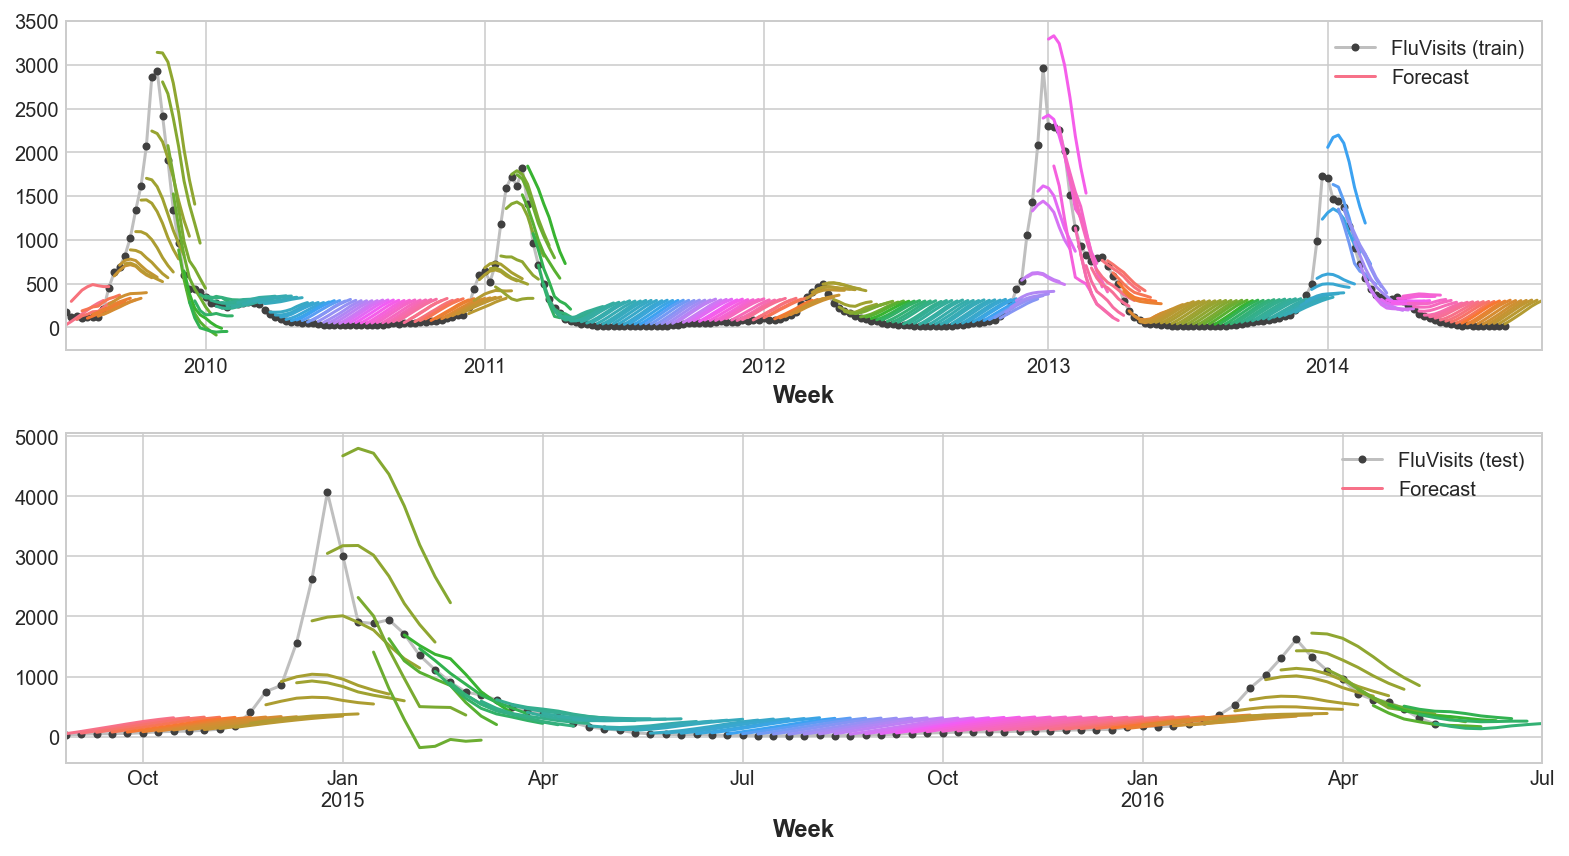

In [7]:
train_rmse = mean_squared_error(y_train, y_fit)
test_rmse = mean_squared_error(y_test, y_pred)
# train_rmse = mean_squared_error(y_train, y_fit, squared=False)
# test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

### 直接策略

XGBoost 不能為迴歸任務生成多個輸出。 但是通過應用直接減少策略，我們仍然可以使用它來生成多步預測。 這就像用 scikit-learn 的 `MultiOutputRegressor` 包裝它一樣簡單。

In [8]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

這裡的 XGBoost 顯然在訓練集上過度擬合。 但在測試集上，它似乎能夠比線性迴歸模型更好地捕捉到流感季節的一些動態。 通過一些超參數調整它可能會做得更好。

Train RMSE: 2.02
Test RMSE: 293007.27


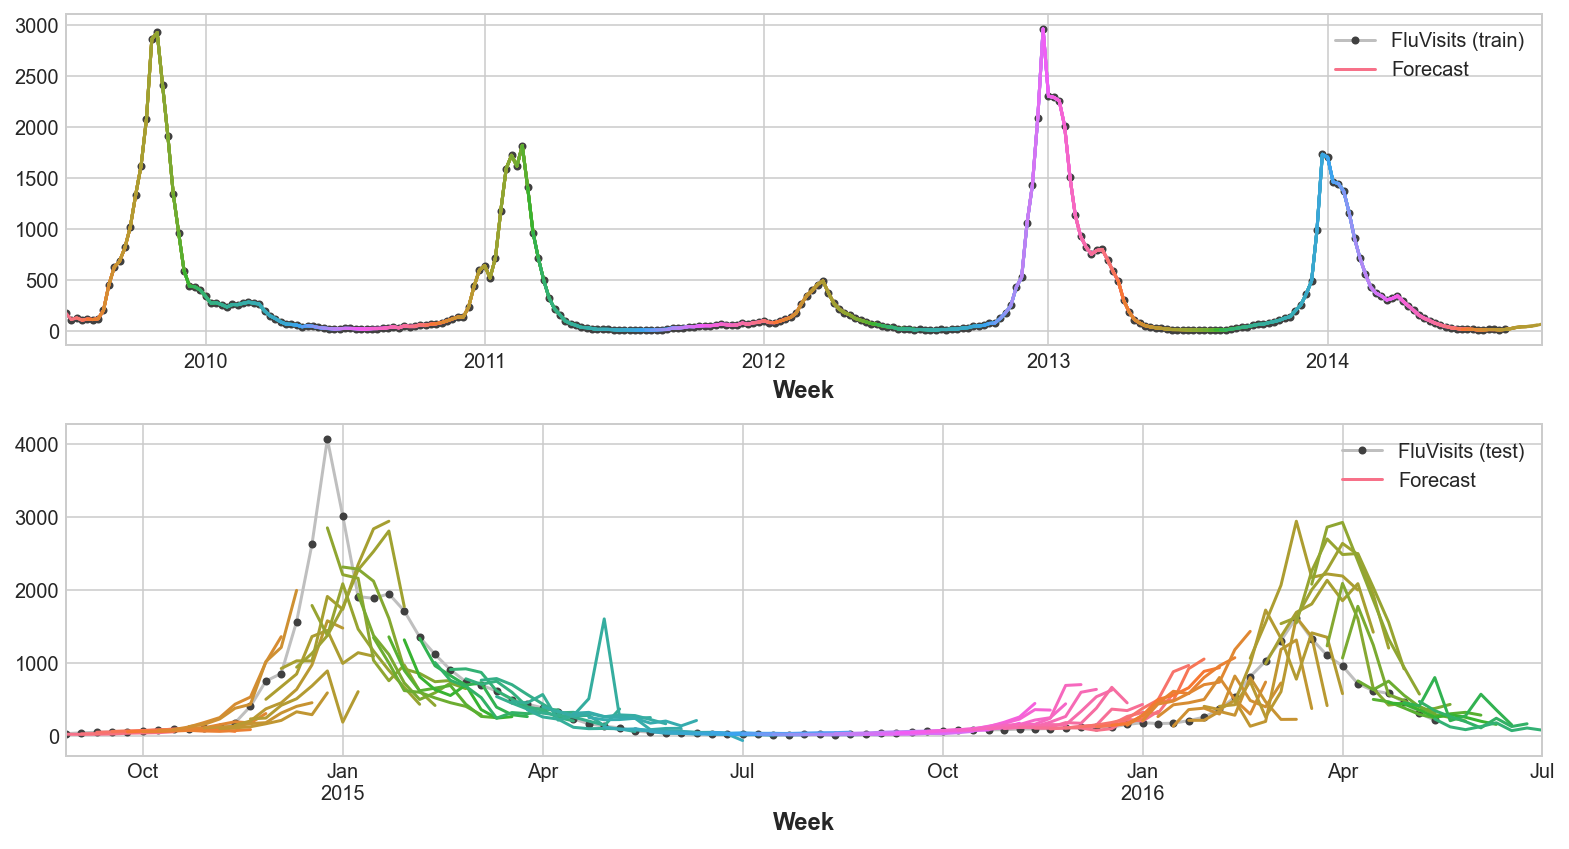

In [10]:
train_rmse = mean_squared_error(y_train, y_fit)
test_rmse = mean_squared_error(y_test, y_pred)
# train_rmse = mean_squared_error(y_train, y_fit, squared=False)
# test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

要使用 DirRec 策略，我們只需將 `MultiOutputRegressor` 替換為另一個 scikit-learn 包裝器`RegressorChain`。 如果要使用遞歸策略，我們會需要自己coding。

# EXERCISE #

[**Create a forecasting dataset**](https://www.kaggle.com/kernels/fork/20667477) for *Store Sales* and apply the DirRec strategy.